In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox

%matplotlib inline
ox.config(log_console=True)
ox.__version__

'1.1.1'

# I/ Map

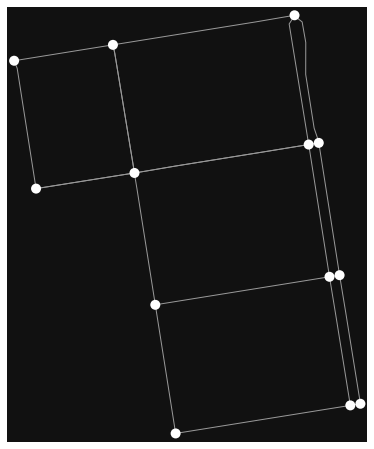

In [2]:
# define a point at the corner of California St and Mason St in SF
location_point = (37.791427, -122.410018)

# create network from point, inside bounding box of N, S, E, W each 100m from point
MDG = ox.graph_from_point(location_point, dist=175, dist_type="bbox", network_type="drive")
fig, ax = ox.plot_graph(MDG, node_color="white", node_size=100)

## A) Graph pre-processing

- [ ] Build regular graph representation from Osmnx graph.
    - Convert osmnx node id to intgers
    - Transform to MultiGraph
- [ ] Make graph eulerian (Chinese postman)

In [3]:
MDG = nx.convert_node_labels_to_integers(MDG) # Use label to deal with node id 
MG = ox.utils_graph.get_undirected(MDG) # MultiDiGraph -> MultiGraph

In [19]:
list(MG.edges(data=True))

[(0,
  1,
  {'osmid': 27166466,
   'oneway': True,
   'name': 'Mason Street',
   'highway': 'residential',
   'length': 107.41299999999998,
   'geometry': <shapely.geometry.linestring.LineString at 0x7f0885fdb0b8>,
   'from': 0,
   'to': 1}),
 (0,
  3,
  {'osmid': 674757876,
   'name': 'California Street',
   'highway': 'tertiary',
   'oneway': False,
   'length': 142.02499999999998,
   'geometry': <shapely.geometry.linestring.LineString at 0x7f0886097400>,
   'from': 3,
   'to': 0}),
 (1,
  2,
  {'osmid': 502795940,
   'oneway': True,
   'lanes': '2',
   'name': 'Pine Street',
   'highway': 'secondary',
   'maxspeed': '30 mph',
   'length': 141.957,
   'geometry': <shapely.geometry.linestring.LineString at 0x7f0886097358>,
   'from': 2,
   'to': 1}),
 (2,
  3,
  {'osmid': 674757881,
   'oneway': True,
   'name': 'Powell Street',
   'highway': 'tertiary',
   'maxspeed': '25 mph',
   'length': 107.72500000000001,
   'geometry': <shapely.geometry.linestring.LineString at 0x7f0886097438>,

In [17]:
class RegGraph:
    """
        Build regular graph representation from Osmnx graph.
    """
    
    def __init__(self, G):
        self.G = G
        self.adjlist = self.create_adjlist(self.G)
        self.adjmat = self.adjlist_to_adjmat(self.adjlist)
        
    def create_adjlist(self, G):
        adjlist = []
        for src, nbrdict in self.G.adjacency():
            tmp = []
            for dst in nbrdict:
                print(src, dst)
                print(nbrdict)
                print(ox.utils_graph.get_route_edge_attributes(G, (src, dst)))
                length = ox.utils_graph.get_route_edge_attributes(G, (src, dst), 'length')[0]
                raise Exception("")
                tmp.append((dst, length))
            adjlist.append((src, tmp))
        return dict(adjlist)

    def adjlist_to_adjmat(self, adjlist):
        n = len(self.adjlist)
        adjmat = [[0 for j in range(n)] for i in range(n)]
        for src in range(n):
            for dst, length in self.adjlist[src]:
                adjmat[src][dst] = length
        return adjmat

    def pretty_print_adjmat(self):
        n = len(self.adjmat)

        print("  ",end="")
        for i in range(n):
            print("{} ".format(i), end="")

        print()

        for i in range(n):
            print("{} ".format(i), end="")
            for j in range(n):
                print(self.adjmat[i][j], end="|")
            print()

In [15]:
graph = RegGraph(MG)
print(graph.adjlist)
print("----")
graph.pretty_print_adjmat()

0 1
[(0, 1, {'osmid': 27166466, 'oneway': True, 'name': 'Mason Street', 'highway': 'residential', 'length': 107.41299999999998, 'geometry': <shapely.geometry.linestring.LineString object at 0x7f0885fdb0b8>, 'from': 0, 'to': 1}), (0, 3, {'osmid': 674757876, 'name': 'California Street', 'highway': 'tertiary', 'oneway': False, 'length': 142.02499999999998, 'geometry': <shapely.geometry.linestring.LineString object at 0x7f0886097400>, 'from': 3, 'to': 0}), (1, 2, {'osmid': 502795940, 'oneway': True, 'lanes': '2', 'name': 'Pine Street', 'highway': 'secondary', 'maxspeed': '30 mph', 'length': 141.957, 'geometry': <shapely.geometry.linestring.LineString object at 0x7f0886097358>, 'from': 2, 'to': 1}), (2, 3, {'osmid': 674757881, 'oneway': True, 'name': 'Powell Street', 'highway': 'tertiary', 'maxspeed': '25 mph', 'length': 107.72500000000001, 'geometry': <shapely.geometry.linestring.LineString object at 0x7f0886097438>, 'from': 3, 'to': 2}), (2, 5, {'osmid': 674757877, 'oneway': True, 'lanes'

Exception: 

## B) Graph traversal

- [ ] `Dfs`

In [51]:
def dfs(visited, graph, node):
    if node not in visited:
        visited.add(node)
        for neighbour, length in graph[node]:
            print(node, neighbour)
            dfs(visited, graph, neighbour)
            
visited = set()
dfs(visited, graph.adjlist, 0)

0 1
1 0
1 2
2 1
2 3
3 0
3 4
4 3
4 5
5 2
5 4
3 2
2 5
0 3


In [52]:
graph.adjlist

{0: [(1, 107.41299999999998), (3, 142.02499999999998)],
 1: [(0, 107.41299999999998), (2, 141.957)],
 2: [(1, 141.957), (3, 107.72500000000001), (5, 8.222999999999999)],
 3: [(0, 142.02499999999998), (4, 8.228), (2, 107.72500000000001)],
 4: [(3, 8.228), (5, 107.75699999999999)],
 5: [(2, 8.222999999999999), (4, 107.75699999999999)]}

- [ ] `find_eulerian_circuit()`

In [45]:
def find_eulerian_circuit_aux(circuit, adjmat, start):
    for i in range(len(adjmat)):
        if adjmat[start][i] > 0:
            adjmat[start][i] = 0
            adjmat[i][start] = 0
            find_eulerian_circuit_aux(circuit, adjmat, i)
    circuit.append(start)
    return circuit

def find_eulerian_circuit(adjmat, start):
    circuit = []
    return find_eulerian_circuit_aux(circuit, adjmat, start)
        
circuit = find_eulerian_circuit(graph.adjmat, 3)
print(circuit[::-1])

[3, 0, 1, 2, 3, 4, 5, 2]


# II/ Benchmark

# III/ Vizualisation